<h2>
    Binary to Decimal!
</h2>
<p>
           While designing a computer on a virtual circuit board, I wanted a quick way to convert a set of binary
        bits to decimal.  One way to do this would have been to write a program (in assembly language, of course)
        to do the conversion.  Another way would have been to construct a ROM which does the conversion instantly
        (rather than having to run a program, which takes valuable clock cycles).  But programming ROMs is boring.
</p>
<p>
        What is fast and not boring?   Using a neural network to <i>learn</i> the logic circuit (effectively, the ROM).
        Because I am lazy and don't want to program a ROM!
</p>

<img src="images/binary_to_decimal_problem_annotated.png">

<p>
    I've framed the problem as follows: 
    <ul> 
        <li>
            Compute a neural network for converting a 10-bit 
            integer [b9 ... b1] to the twelve-bit decimal representation 
            [d2 d1 d0].  This is 12-bits because each decimal place, 
            being a number from 0 - 9, requires 4 bits to specify.
        </li>
        <li>
            Do this in such a way that the neural network easily
            generalizes to larger bit-lengths.  
        </li>
    </ul>
</p>

<img src="images/inputs_and_outputs.png">

In [1]:
import numpy as np
import tensorflow as tf
import keras as K
from keras.layers import Input, Dense, Activation, Bidirectional, LSTM, Reshape, BatchNormalization
from keras.models import Model
import matplotlib.pyplot as plt

from bin2dec_utils import *  # This is where the code is for generating labeled data and constructing Keras models.
import time

Using TensorFlow backend.


In [55]:
X, Y = generate_datapoints(5000)
X = np.reshape(X, (5000,10,1))
Y = np.reshape(Y, (5000,12))

In [14]:
# Each model name corresonds to its hidden layers.  The last hidden layer feeds into the final 12-bit output layer with
# dense connection
model_20b = model_1layer(a_h=20) # 20 unit bi-LSTM
model_40b = model_1layer(a_h=40) # 40 unit bi-LSTM
model_20b_40 = model_2layer(a_h1=20, a_h2=40) # 20 unit bi-LSTM followed by 40 unit LSTM
model_40b_40 = model_2layer(a_h1=40, a_h2=40) # 40 unit bi-LSTM followed by 40 unit LSTM
model_40b_40b_40 = model_3layer(a_h1=40, a_h2=40, a_h3=40) # 40 unit bi-LSTM, 40 unit bi-LSTM, 40 unit lSTM
model_40d_40d_40d = dense_model(a_h=40) # Three 40 unit dense hidden layers
model_names = ["20b", "40b", "20b_40", "40b_40", "40b_40b_40", "40d_40d_40d"]
models = [model_20b, model_40b, model_20b_40, model_40b_40, model_40b_40_40, model_40d_40d_40d]

In [62]:
histories = []
for i in range(6):
    models[i].compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    start = time.time()
    histories.append(models[i].fit(X,Y,epochs=200, batch_size=250, verbose=0))
    end = time.time()
    print("Finished training model", model_names[i], ". It took", (end-start), "seconds for 200 epochs of batch size 250.")

Finished training model 20b . It took 35.85789155960083 seconds for 200 epochs of batch size 250.
Finished training model 40b . It took 49.99222016334534 seconds for 200 epochs of batch size 250.
Finished training model 20b_40 . It took 143.80993223190308 seconds for 200 epochs of batch size 250.
Finished training model 40b_40 . It took 211.37531113624573 seconds for 200 epochs of batch size 250.
Finished training model 40b_40_40 . It took 481.0224063396454 seconds for 200 epochs of batch size 250.
Finished training model 40d_40d_40d . It took 19.37522840499878 seconds for 200 epochs of batch size 250.


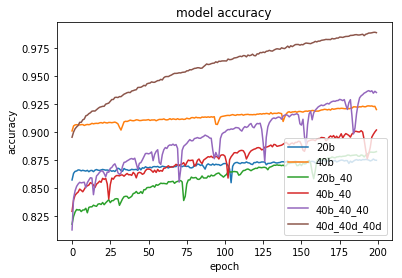

In [64]:
plt.gcf().clear()
for i in range(6):
    plt.plot(histories[i].history['acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(model_names, loc='lower right')
plt.show()

<h2>
Conclusions
</h2>

<div class="row">
  <div class="column">
    <figure>
        <img src="images/binary_to_decimal_problem.png" style="width:33%">
        <figcaption>The initial problem</figcaption>
    </figure>
  </div>
  <div class="column">
      <figure>
          <img src="images/bi_LSTM_attempt.png" style="width:33%">
          <figcaption>All attempts with bi-directional LSTMS were slow and bad.</figcaption>
      </figure>
  </div>
  <div class="column">
       <figure>
           <img src="images/dense_attempt.png" style="width:33%">
           <figcaption>Plain dense layers were much more appropriate.</figcaption>
       </figure>
  </div>
</div>

<br/>
<p>
    This is somewhat disappointing.  While plain dense layers are easy to train 
    and probably on their way toward 100% accuracy (with some more training) 
    I'm afraid they won't generalize as well.  I imagined that LSTMs might be
    able to learn a more elegant algorithm.  
</p>
<p>
    Below is a sample output of the dense neural network.  
</p>

In [71]:
i = 103
test_input = X[i]
print("input bits: ", np.reshape(test_input,(10)))
test_output = Y[i]
print("label bits: ", test_output)
test_output_readable = decbits_to_dec(Y[i])
print("label number: ", test_output_readable)
model_prediction_logits = np.reshape(model_40d_40d_40d.predict(np.reshape(test_input,(1,10,1))),(12))
print("model prediction bits (before rounding): ", model_prediction_logits)
model_prediction = np.round(model_prediction_logits)
print("model prediction bits (after rounding): ", model_prediction)
model_prediction_readable = decbits_to_dec(model_prediction)
print("model prediction: ", model_prediction_readable)

input bits:  [1. 1. 0. 1. 0. 1. 0. 0. 0. 0.]
label bits:  [1 0 0 0 0 1 0 0 1 0 0 0]
label number:  848
model prediction bits (before rounding):  [9.9999177e-01 2.1318572e-04 1.3795028e-09 4.2741140e-09 1.0014876e-03
 9.9997652e-01 2.7419066e-03 1.8301813e-02 9.0361184e-01 1.1434668e-04
 4.6061622e-03 7.9113524e-06]
model prediction bits (after rounding):  [1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0.]
model prediction:  848


<p>
    Not only are predictions of the 3-layer dense network correct, but most are quite confidently so. 
</p>